<a href="https://colab.research.google.com/github/yiwenwangANU/pytorch_learning/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sklearn

## Data preparing
create dummy data for classification, use model from
https://scikit-learn.org/dev/modules/generated/sklearn.datasets.make_circles.html

In [2]:
from sklearn.datasets import make_circles

n_examples = 1000

X, y = make_circles(n_examples, noise=0.03, random_state=42)

In [3]:
X[:5]

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343]])

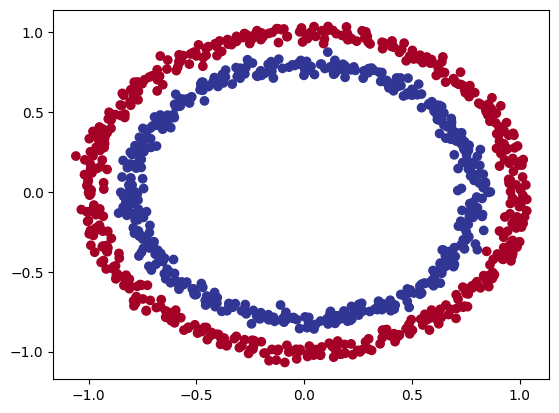

In [4]:
# visualize the data
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [5]:
# turn data into tensors
import torch

type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [6]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

type(X), X.dtype

(torch.Tensor, torch.float32)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [8]:
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

##Setup device agnostic code

In [9]:
from torch import nn

# need to switch to GPU in colab first
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

##Build the model

In [10]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=5)
    self.layer2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer2(self.layer1(x))

model_0 = CircleModelV0().to(device)

In [11]:
# using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.ReLU(),
    nn.Linear(in_features=5, out_features=1,),
    nn.Tanh()
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Tanh()
)

In [12]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.2032,  0.1572],
                      [ 0.0968,  0.6897],
                      [-0.3351,  0.4644],
                      [-0.0648, -0.4029],
                      [-0.2193, -0.0808]])),
             ('0.bias', tensor([ 0.1839,  0.2348, -0.4870,  0.4593, -0.3720])),
             ('2.weight',
              tensor([[ 0.3708, -0.2623,  0.3423, -0.1285, -0.1256]])),
             ('2.bias', tensor([-0.3618]))])

## Loss, optimizer, accuracy function and training loop

In [13]:
loss_fn = nn.BCEWithLogitsLoss() # sigmoid layer + Binary Cross Entropy loss
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [14]:
def accuracy_fu(y_pred, y_true):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = correct/len(y_true) *100
  return acc

In [15]:
epoches = 100
loss_values = []
accuracy_values = []
y_preds = []
torch.manual_seed(42);
torch.cuda.manual_seed(42);

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epoches):
  model_0.train()

  y_logit = model_0(X_train).squeeze()
  y_prob = torch.sigmoid(y_logit)
  y_pred = torch.round(y_prob)
  y_preds.append(y_pred)

  loss = loss_fn(y_logit, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if(epoch % 5 == 0):
    model_0.eval()
    with torch.inference_mode():
      test_logit = model_0(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logit))
      accuracy_training = accuracy_fu(y_pred,y_train)
      accuracy_testing = accuracy_fu(test_pred,y_test)
      loss_values.append(loss)
      accuracy_values.append(accuracy_training)
      print(f'epoch: {epoch}, loss: {loss}, training accuracy: {accuracy_training}, testing accuracy: {accuracy_testing}')

epoch: 0, loss: 0.7136671543121338, training accuracy: 50.0, testing accuracy: 50.0
epoch: 5, loss: 0.7086146473884583, training accuracy: 50.0, testing accuracy: 50.0
epoch: 10, loss: 0.7040660977363586, training accuracy: 50.0, testing accuracy: 50.0
epoch: 15, loss: 0.7005192041397095, training accuracy: 50.0, testing accuracy: 50.0
epoch: 20, loss: 0.698000967502594, training accuracy: 50.0, testing accuracy: 50.0
epoch: 25, loss: 0.6961662769317627, training accuracy: 50.0, testing accuracy: 50.0
epoch: 30, loss: 0.6948273181915283, training accuracy: 50.0, testing accuracy: 50.0
epoch: 35, loss: 0.6938571929931641, training accuracy: 50.0, testing accuracy: 50.0
epoch: 40, loss: 0.6931686997413635, training accuracy: 47.125, testing accuracy: 47.5
epoch: 45, loss: 0.6926780939102173, training accuracy: 47.875, testing accuracy: 50.0
epoch: 50, loss: 0.6923274993896484, training accuracy: 48.125, testing accuracy: 51.5
epoch: 55, loss: 0.6920710206031799, training accuracy: 49.25,

In [16]:
loss_values[:5]

[tensor(0.7137, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 tensor(0.7086, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 tensor(0.7041, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 tensor(0.7005, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 tensor(0.6980, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)]

In [17]:
y_pred = torch.round(torch.sigmoid(model_0(X_train[:5].to(device)))).squeeze(1)
y_pred

tensor([0., 0., 1., 1., 0.], grad_fn=<SqueezeBackward1>)

In [18]:
y_train[:5]

tensor([1., 0., 0., 0., 1.])

In [19]:
from pathlib import Path
if(Path('helper_functions.py').is_file()):
  print('helper functions already exist!')
else:
  !wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py

--2024-12-01 22:41:43--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10160 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.92K  --.-KB/s    in 0s      

2024-12-01 22:41:43 (97.9 MB/s) - ‘helper_functions.py’ saved [10160/10160]



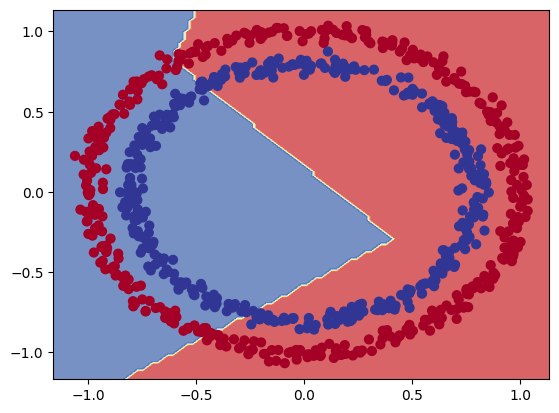

In [20]:
from helper_functions import plot_decision_boundary, plot_predictions
plot_decision_boundary(model_0, X_train, y_train)

In [21]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    z = self.layer1(x)
    z = self.layer2(z)
    z = self.layer3(z)
    return z

model_1 = CircleModelV1().to(device)

In [22]:
loss_fn_1 = nn.BCEWithLogitsLoss()
optimizer_1 = torch.optim.SGD(params=model_1.parameters(), lr=.01)

In [23]:
epoches = 1000
for epoch in range(epoches):
  model_1.train()
  y_logit = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logit))
  loss = loss_fn_1(y_logit, y_train)
  accuracy = accuracy_fu(y_pred=y_pred, y_true=y_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    if(epoch % 100 == 0):
      test_logit = model_1(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logit))
      test_loss = loss_fn_1(test_logit, y_test)
      test_acc = accuracy_fu(y_pred=test_pred, y_true=y_test)
      print(f'epoch: {epoch}, train loss: {loss:.5f}, train accuracy: {accuracy:.2f}, test loss: {test_loss:.5f}, test accuracy: {test_acc:.5f}')



epoch: 0, train loss: 0.69396, train accuracy: 50.88, test loss: 0.69261, test accuracy: 51.00000
epoch: 100, train loss: 0.69396, train accuracy: 50.88, test loss: 0.69261, test accuracy: 51.00000
epoch: 200, train loss: 0.69396, train accuracy: 50.88, test loss: 0.69261, test accuracy: 51.00000
epoch: 300, train loss: 0.69396, train accuracy: 50.88, test loss: 0.69261, test accuracy: 51.00000
epoch: 400, train loss: 0.69396, train accuracy: 50.88, test loss: 0.69261, test accuracy: 51.00000
epoch: 500, train loss: 0.69396, train accuracy: 50.88, test loss: 0.69261, test accuracy: 51.00000
epoch: 600, train loss: 0.69396, train accuracy: 50.88, test loss: 0.69261, test accuracy: 51.00000
epoch: 700, train loss: 0.69396, train accuracy: 50.88, test loss: 0.69261, test accuracy: 51.00000
epoch: 800, train loss: 0.69396, train accuracy: 50.88, test loss: 0.69261, test accuracy: 51.00000
epoch: 900, train loss: 0.69396, train accuracy: 50.88, test loss: 0.69261, test accuracy: 51.00000


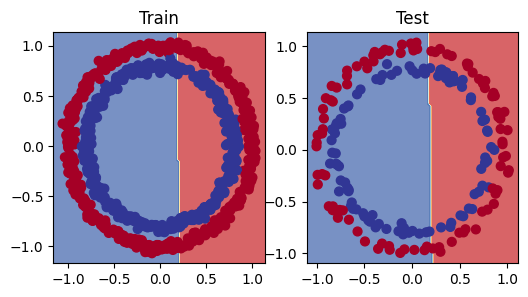

In [24]:
plt.figure(figsize=(6, 3))
plt.subplot(1 ,2 ,1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1 ,2 ,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## Define the model

In [25]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

## loss and optimizer

In [26]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

##Training

In [29]:
epoches = 3000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epoches):
  model_2.train()
  y_logit = model_2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logit))
  loss = loss_fn(y_logit, y_train)
  accuracy = accuracy_fu(y_pred=y_pred, y_true=y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    if(epoch % 100 == 0):
      test_logit = model_2(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logit))
      test_loss = loss_fn(y_test, test_logit)
      test_acc = accuracy_fu(y_pred=test_pred, y_true=y_test)
      print(f'epoch: {epoch}, train loss: {loss:5f}, train accuracy: {accuracy:2f}, test loss: {test_loss:5f}, test accuracy: {test_acc:2f}')


epoch: 0, train loss: 0.672982, train accuracy: 59.625000, test loss: 0.973246, test accuracy: 59.500000
epoch: 100, train loss: 0.666605, train accuracy: 61.125000, test loss: 0.964110, test accuracy: 62.000000
epoch: 200, train loss: 0.655903, train accuracy: 64.250000, test loss: 0.950751, test accuracy: 65.000000
epoch: 300, train loss: 0.639003, train accuracy: 67.500000, test loss: 0.935479, test accuracy: 69.000000
epoch: 400, train loss: 0.607377, train accuracy: 74.000000, test loss: 0.911110, test accuracy: 74.500000
epoch: 500, train loss: 0.547652, train accuracy: 90.000000, test loss: 0.856788, test accuracy: 85.000000
epoch: 600, train loss: 0.448905, train accuracy: 96.750000, test loss: 0.742509, test accuracy: 94.500000
epoch: 700, train loss: 0.324886, train accuracy: 99.000000, test loss: 0.536877, test accuracy: 98.500000
epoch: 800, train loss: 0.211872, train accuracy: 99.875000, test loss: 0.288900, test accuracy: 99.000000
epoch: 900, train loss: 0.156599, train

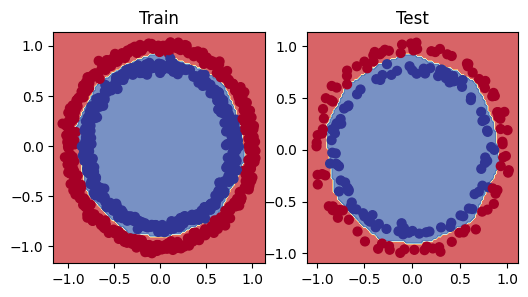

In [30]:
plt.figure(figsize=(6,3))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_2, X_test, y_test)